# Hospital Inpatient Discharges (SPARCS De-identified): 2017
Source: New York State Health Department
https://health.data.ny.gov/dataset/Hospital-Inpatient-Discharges-SPARCS-De-Identified/22g3-z7e7

Goal is to predict Risk of Mortality to better inform treatment, aggresivness of approach, expectations of family...

In [113]:
import pandas as pd
import numpy as np

In [114]:
# Using Hospital Inpatient Discharge information for the State of New York from 2017

df= pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2017.csv', low_memory= False)

In [115]:
print(df.shape)
df.head()

(2343569, 34)


,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,...,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,30 to 49,NaN,M,White,Not Span/Hispanic,21,Elective,...,2,Moderate,Minor,Medical,Medicare,Medicare,Self-Pay,NaN,N,N,114168.00,40464.04
1,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,M,White,Spanish/Hispanic,8,Emergency,...,3,Major,Moderate,Medical,Medicaid,Medicaid,Self-Pay,NaN,N,N,58517.00,26046.50
2,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,30 to 49,105,F,White,Unknown,6,Emergency,...,2,Moderate,Moderate,Medical,Department of Corrections,Self-Pay,NaN,NaN,N,N,39647.04,17397.59
3,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,F,White,Not Span/Hispanic,4,Emergency,...,2,Moderate,Moderate,Medical,Medicaid,Medicaid,Self-Pay,NaN,N,N,36031.09,16118.84
4,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,18 to 29,105,F,White,Spanish/Hispanic,4,Emergency,...,2,Moderate,Minor,Medical,Department of Corrections,Self-Pay,NaN,NaN,N,N,30534.00,11921.05


## Exploration of target

**The target that I want to predict is APR Risk of Mortality.**

This is an important target as it will dictate certain decisions such as treatments, aggresiveness of care, familial preparations for the worst outcome etc...
- Ordinal rank Minor(1), Moderate(2), Major(3), Extreme(4)

It is important to determine this metric early on in the process of treating the patient as this is a crucial piece of information in creating efficient and effective treatment plans for higher risk patients.

As such, while doing feature selection we will consider the time frame of when certain features are available in order to implement the model earlier in the inpatient process.

In [116]:
# Ordinal encode
df['APR Risk of Mortality'] = df['APR Risk of Mortality'].replace({
    'Minor': 1,
    "Moderate": 2,
    "Major": 3,
    "Extreme": 4
})

In [117]:
# Target is 'APR Risk of Mortality'

# Look at target statistics
df['APR Risk of Mortality'].describe()

count    2.343329e+06
mean     1.691481e+00
std      9.164827e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.000000e+00
Name: APR Risk of Mortality, dtype: float64

In [118]:
# Value counts

df['APR Risk of Mortality'].value_counts()

1.0    1338452
2.0     508068
3.0     378128
4.0     118681
Name: APR Risk of Mortality, dtype: int64

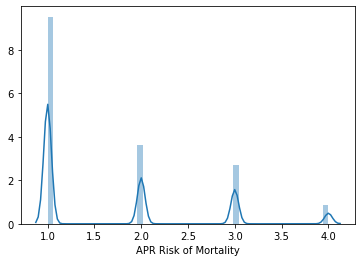

In [119]:
# Visual exploration of the column

import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(df['APR Risk of Mortality']);

My problem is a multi-class classification

In [120]:
# Distribution of target classes

df['APR Risk of Mortality'].value_counts(normalize= True)

1.0    0.571175
2.0    0.216815
3.0    0.161364
4.0    0.050646
Name: APR Risk of Mortality, dtype: float64

The majority class (1) for my target is is 57%. <br>
I will use accuracy and average weighted f1 score as my evaluation metrics
- Average f1-scores are used for multi-class targets
- Weighted average f1-score will account for the label inbalance in my target

I will use a random split to train/val/test my data as all observations are within the same year. <br>

## Feature Exploration

**Features to exclude** <br>
Not applicable to target (Either unique identifier or information gathered at the end of a patients treatment which is not useful as the model needs to be applied earlier)
- Operating Certificate Number (Unique ID for the hospital)
- Patient Disposition (Destination upon discharge)
- Discharge year (The entire dataset is for the year 2017) 
- Total charges (Information not collected until the end of treatment)
- Total cost (Information not collected until the end of treatment)
- Birth weight (only applicable to newborns)


Redundant: All of the codes have a description column. I will pull them out as a reference table, but for my model they are redundant.
- CCS Diagnosis Description
- CCS Procedure Description
- APR DRG Description
- APR MDC Description


Potential data leakage:
- APR Severity of Illness code (Might have a direct correlation to APR Risk of Mortality)
    - Every time there is a 0 for APR Severity of Illness Code, there is a np.nan for APR Risk of Mortality
    - Upon further exploration below, I have decided to omit this column as 60% of the time it is the exact same value as APR Risk of Mortality


Use the below features to create an engineered feature of patient distance to hospital

- Permanent Facility Id
- Facility Name
- Hospital Service Area
- Hospital Country
- Zip code 

## Reference Tables
- Matches descriptions with codes

In [121]:
# Create a reference table for codes and their descriptions
# We will be dropping the descriptions

# CCS Diagnosis
codes_diagnosis = df.groupby('CCS Diagnosis Description')['CCS Diagnosis Code'].mean()
codes_diagnosis = pd.DataFrame(codes_diagnosis)

# CCS Procedure
codes_procedure = df.groupby('CCS Procedure Description')['CCS Procedure Code'].mean()
codes_procedure = pd.DataFrame(codes_procedure)

# APR DRG
codes_drg = df.groupby('APR DRG Description')['APR DRG Code'].mean()
codes_drg = pd.DataFrame(codes_drg)

# APR MDC
codes_mdc = df.groupby('APR MDC Description')['APR MDC Code'].mean()
codes_mdc = pd.DataFrame(codes_mdc)

# APR Severity of Illness
codes_illness = df.groupby('APR Severity of Illness Description')['APR Severity of Illness Code'].mean()
codes_illness = pd.DataFrame(codes_illness)

## Initial Data Cleaning

In [122]:
# Change pandas display so you can see all of the columns at once

pd.set_option('display.max_columns', 25)

In [211]:
# Drop unnecessary features as commented above

df_cleaned = df.drop([
    'Operating Certificate Number',
    'Patient Disposition',
    'Discharge Year',
    'CCS Diagnosis Description',
    'CCS Procedure Description',
    'APR DRG Description',
    'APR MDC Description',
    'Birth Weight',
    'Total Charges',
    'Total Costs',
    'APR Severity of Illness Description'
],
    axis= 1

)
df_cleaned.head()

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
0,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,30 to 49,NaN,M,White,Not Span/Hispanic,21,Elective,659,0,750,19,2,1.0,Medical,Medicare,Medicare,Self-Pay,N,N
1,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,M,White,Spanish/Hispanic,8,Emergency,99,108,194,5,3,2.0,Medical,Medicaid,Medicaid,Self-Pay,N,N
2,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,30 to 49,105,F,White,Unknown,6,Emergency,161,102,465,11,2,2.0,Medical,Department of Corrections,Self-Pay,NaN,N,N
3,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,F,White,Not Span/Hispanic,4,Emergency,238,222,721,18,2,2.0,Medical,Medicaid,Medicaid,Self-Pay,N,N
4,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,18 to 29,105,F,White,Spanish/Hispanic,4,Emergency,2,0,720,18,2,1.0,Medical,Department of Corrections,Self-Pay,NaN,N,N


In [212]:
# Look at null values
df_cleaned.isnull().sum()

Hospital Service Area                  5155
Hospital County                        5155
Permanent Facility Id                  5155
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   39019
Gender                                    0
Race                                      0
Ethnicity                                 0
Length of Stay                            0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                   240
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   878722
Payment Typology 3                  1737244
Abortion Edit Indicator                   0
Emergency Department Indicator  

In [213]:
# Explore missing values in target

missing_illness = df[df['APR Risk of Mortality'].isnull() == True]
missing_illness['Type of Admission'].value_counts(normalize = True)

Newborn      0.745833
Emergency    0.120833
Urgent       0.070833
Elective     0.062500
Name: Type of Admission, dtype: float64

In [214]:
# Drop missing values in target (only 0.01%)
# They were mostly (74.5%) newborn babies which we are not including in our model

df_cleaned.dropna(subset= ['APR Risk of Mortality'], inplace= True)

## Data exploration 

In [215]:
# Look at numeric traits
df_cleaned.describe()

,Permanent Facility Id,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality
count,2.338179e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06
mean,1.038966e+03,1.898662e+02,1.013940e+02,4.161252e+02,1.031172e+01,2.020953e+00,1.691481e+00
std,7.202033e+02,1.649466e+02,8.681344e+01,2.424451e+02,5.899823e+00,8.889587e-01,9.164827e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,5.410000e+02,1.010000e+02,0.000000e+00,1.980000e+02,5.000000e+00,1.000000e+00,1.000000e+00
50%,1.097000e+03,1.570000e+02,9.800000e+01,3.830000e+02,9.000000e+00,2.000000e+00,1.000000e+00
75%,1.453000e+03,2.180000e+02,1.800000e+02,6.400000e+02,1.500000e+01,3.000000e+00,2.000000e+00
max,9.431000e+03,2.617000e+03,2.310000e+02,9.520000e+02,2.500000e+01,4.000000e+00,4.000000e+00


In [216]:
# Look at categorical traits
df_cleaned.describe(exclude= 'number')

,Hospital Service Area,Hospital County,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
count,2338179,2338179,2343329,2343329,2304316,2343329,2343329,2343329,2343329,2343329,2343329,2343329,1464708,606295,2343329,2343329
unique,8,57,211,5,50,3,4,4,120,6,2,10,10,10,2,2
top,New York City,Manhattan,Mount Sinai Hospital,70 or Older,112,F,White,Not Span/Hispanic,2,Emergency,Medical,Medicare,Medicaid,Self-Pay,N,Y
freq,1070407,395687,52335,664780,293826,1296822,1316956,1895507,546084,1500436,1742545,906899,529653,400972,2339978,1373723


In [217]:
# Look at different label names for spelling mistakes etc...
df_cleaned['Emergency Department Indicator'].value_counts().index.tolist()

['Y', 'N']

In [248]:
# Look at null values, we will need to impute
df_cleaned.isnull().sum()

Hospital Service Area               0
Hospital County                     0
Permanent Facility Id               0
Facility Name                       0
Age Group                           0
Zip Code - 3 digits                 0
Gender                              0
Race                                0
Ethnicity                           0
Length of Stay                      0
Type of Admission                   0
CCS Diagnosis Code                  0
CCS Procedure Code                  0
APR DRG Code                        0
APR MDC Code                        0
APR Severity of Illness Code        0
APR Risk of Mortality               0
APR Medical Surgical Description    0
Payment Typology 1                  0
Payment Typology 2                  0
Payment Typology 3                  0
Abortion Edit Indicator             0
Emergency Department Indicator      0
dtype: int64

### Explore relationship between APR Severity of Illness and target for potential data leakage

In [219]:
# Create subset of just the two columns
data_leak = df_cleaned[['APR Severity of Illness Code', 'APR Risk of Mortality']]
data_leak

,APR Severity of Illness Code,APR Risk of Mortality
0,2,1.0
1,3,2.0
2,2,2.0
3,2,2.0
4,2,1.0
...,...,...
2343564,1,2.0
2343565,2,2.0
2343566,1,1.0
2343567,2,1.0


In [220]:
# Look a statistical features
data_leak.describe()

,APR Severity of Illness Code,APR Risk of Mortality
count,2.343329e+06,2.343329e+06
mean,2.020953e+00,1.691481e+00
std,8.889587e-01,9.164827e-01
min,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00
75%,3.000000e+00,2.000000e+00
max,4.000000e+00,4.000000e+00


In [221]:
# Count how many times they are not equivalent

# Convert APR Risk of Mortality to integer
data_leak['APR Risk of Mortality'] = data_leak['APR Risk of Mortality'].astype(int)

# Pull out subset of when the two columns are not equivalent
subset = data_leak[data_leak['APR Risk of Mortality'] != data_leak['APR Severity of Illness Code']]
subset

/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,APR Severity of Illness Code,APR Risk of Mortality
0,2,1
1,3,2
4,2,1
6,2,1
10,2,1
...,...,...
2343561,3,2
2343563,2,1
2343564,1,2
2343567,2,1


In [222]:
# Proportion of when these two columns are the same
1 - len(subset) / len(df_cleaned)

0.5913587037927666

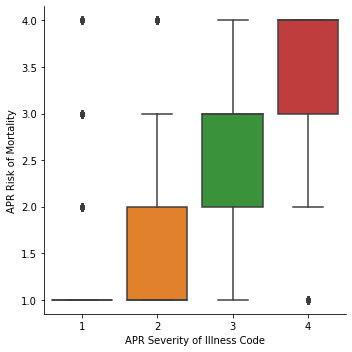

In [223]:
# Visual of relationship
import seaborn as sns
sns.catplot(x= 'APR Severity of Illness Code', y= 'APR Risk of Mortality', kind= 'box', data= data_leak);

**In conclusion I will drop APR Severity of Illness code for two reasons**
- First, it is too similar to the target. 59% of the time they are the exact same value.
- Second, in practice I would want to implement the model before necessarily knowing the severity of the illness. By the time you know the severity of the illness, my model would not provide you with very much additional useful information.

### Explore Redacted Data
- 5150 rows with redacted geographic information
- Labeled 'Redacted for Confidentiality'

In [224]:
# Pull out the redacted information
redacted = df_cleaned[df_cleaned['Facility Name'] == 'Redacted for Confidentiality']
redacted

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
28,NaN,NaN,NaN,Redacted for Confidentiality,0 to 17,NaN,F,White,Not Span/Hispanic,2,Emergency,229,148,315,8,2,1.0,Surgical,Blue Cross/Blue Shield,Self-Pay,NaN,N,N
595,NaN,NaN,NaN,Redacted for Confidentiality,18 to 29,NaN,F,White,Not Span/Hispanic,1,Urgent,181,222,564,14,1,1.0,Medical,Blue Cross/Blue Shield,Medicaid,NaN,Y,N
839,NaN,NaN,NaN,Redacted for Confidentiality,18 to 29,NaN,F,Black/African American,Not Span/Hispanic,1,Emergency,177,127,544,14,1,1.0,Surgical,Medicaid,Medicaid,Self-Pay,Y,N
2227,NaN,NaN,NaN,Redacted for Confidentiality,0 to 17,NaN,F,Other Race,Spanish/Hispanic,1,Emergency,195,126,560,14,2,1.0,Medical,Medicaid,NaN,NaN,Y,Y
2723,NaN,NaN,NaN,Redacted for Confidentiality,30 to 49,NaN,F,Black/African American,Not Span/Hispanic,1,Emergency,180,123,545,14,1,1.0,Surgical,Medicaid,NaN,NaN,Y,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342722,NaN,NaN,NaN,Redacted for Confidentiality,0 to 17,NaN,M,White,Spanish/Hispanic,2,Newborn,218,115,640,15,1,1.0,Medical,Medicaid,NaN,NaN,N,N
2342742,NaN,NaN,NaN,Redacted for Confidentiality,70 or Older,NaN,U,White,Not Span/Hispanic,4,Emergency,99,0,194,5,2,2.0,Medical,Medicare,Medicaid,NaN,N,Y
2342768,NaN,NaN,NaN,Redacted for Confidentiality,30 to 49,NaN,M,Black/African American,Not Span/Hispanic,1,Emergency,83,0,53,1,1,1.0,Medical,Medicaid,NaN,NaN,N,Y
2342862,NaN,NaN,NaN,Redacted for Confidentiality,30 to 49,NaN,F,White,Not Span/Hispanic,1,Emergency,178,127,544,14,2,1.0,Surgical,Medicaid,Medicaid,NaN,Y,Y


In [225]:
# Explore redacted rows
redacted.describe()

,Permanent Facility Id,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality
count,0.0,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000
mean,NaN,196.830097,110.588544,526.164854,13.269320,1.726602,1.329903
std,NaN,125.279172,67.198097,158.935758,3.970063,0.755514,0.659645
min,NaN,2.000000,0.000000,4.000000,1.000000,1.000000,1.000000
25%,NaN,177.000000,87.000000,544.000000,14.000000,1.000000,1.000000
50%,NaN,179.000000,126.000000,545.000000,14.000000,2.000000,1.000000
75%,NaN,180.000000,131.000000,564.000000,14.000000,2.000000,1.000000
max,NaN,2617.000000,231.000000,952.000000,25.000000,4.000000,4.000000


In [226]:
redacted.describe(exclude = 'number')

,Hospital Service Area,Hospital County,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
count,0,0,5150,5150,0,5150,5150,5150,5150,5150,5150,5150,2519,877,5150,5150
unique,0,0,1,5,0,3,4,4,55,6,2,10,10,7,2,2
top,NaN,NaN,Redacted for Confidentiality,30 to 49,NaN,F,Other Race,Not Span/Hispanic,1,Emergency,Surgical,Medicaid,Medicaid,Self-Pay,Y,Y
freq,NaN,NaN,5150,2175,NaN,4215,1788,2755,2537,3873,2693,2671,1409,705,3351,3559


In [227]:
# 65% of the redacted information was because they were abortions
# Will drop these rows because abortion indicator has zero effect on my model
redacted['Abortion Edit Indicator'].value_counts(normalize= True)

Y    0.65068
N    0.34932
Name: Abortion Edit Indicator, dtype: float64

In [228]:
# Look at the distribution of various features within redacted subset
# Looking to see if there is a specific reason these were redacted

redacted['APR Severity of Illness Code'].value_counts(normalize= True)

1    0.436505
2    0.423301
3    0.117282
4    0.022913
Name: APR Severity of Illness Code, dtype: float64

Will drop rows with redacted information because 65% are redacted due to being an abortion (abortion indicator has zero impact on my model). The rest maintain a normal distribution throughout the features so I will not be losing any information by dropping them (0.078% of observations). 

In [230]:
# Dropped redacted observations
df_cleaned.dropna(subset= ['Hospital County'], inplace= True)

In [233]:
# Check that redacted observations were dropped
print(df_cleaned.shape)
df_cleaned.isnull().sum()

(2338179, 23)


Hospital Service Area                     0
Hospital County                           0
Permanent Facility Id                     0
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   33863
Gender                                    0
Race                                      0
Ethnicity                                 0
Length of Stay                            0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                     0
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   875990
Payment Typology 3                  1732761
Abortion Edit Indicator                   0
Emergency Department Indicator  

### Clean zip code
- I want to replace missing zip codes with the most frequent for the county that the hospital is located in

In [ ]:
# Define a function that will take the most frequent 

def manual_mode(X):
    manmode = X.copy()
    try: manmode = manmode.value_counts().index[0]
    except: pass
    return manmode

In [ ]:
# Use the previously defined function to fill null values with most frequent zip code grouped by Hospital County

df_cleaned['Zip Code - 3 digits'] = df_cleaned['Zip Code - 3 digits'].fillna(df_cleaned.groupby('Hospital County')['Zip Code - 3 digits'].transform(manual_mode))


In [243]:
df_cleaned.isnull().sum()

Hospital Service Area                     0
Hospital County                           0
Permanent Facility Id                     0
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                       0
Gender                                    0
Race                                      0
Ethnicity                                 0
Length of Stay                            0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                     0
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   875990
Payment Typology 3                  1732761
Abortion Edit Indicator                   0
Emergency Department Indicator  

### Clean Payment Typology 2 and 3
- Replace missing values with 'None'
- These patients only used one type of payment, didn't need type 2 or 3

In [246]:
# Replace missing values of Payment Typology 2 and 3 with 'None', they only used one type of payment
df_cleaned['Payment Typology 2']= df_cleaned['Payment Typology 2'].replace({np.nan: 'None'})
df_cleaned['Payment Typology 3']= df_cleaned['Payment Typology 3'].replace({np.nan: 'None'})

In [247]:
# Check which null values are left to clean

df_cleaned.isnull().sum()

Hospital Service Area               0
Hospital County                     0
Permanent Facility Id               0
Facility Name                       0
Age Group                           0
Zip Code - 3 digits                 0
Gender                              0
Race                                0
Ethnicity                           0
Length of Stay                      0
Type of Admission                   0
CCS Diagnosis Code                  0
CCS Procedure Code                  0
APR DRG Code                        0
APR MDC Code                        0
APR Severity of Illness Code        0
APR Risk of Mortality               0
APR Medical Surgical Description    0
Payment Typology 1                  0
Payment Typology 2                  0
Payment Typology 3                  0
Abortion Edit Indicator             0
Emergency Department Indicator      0
dtype: int64

## Split into train/val/test using random split

In [249]:
from sklearn.model_selection import train_test_split

# Split train data into train and test, 80/20 split

train, test = train_test_split(df_cleaned, train_size=0.85, test_size=0.15, 
                              stratify=df_cleaned['APR Risk of Mortality'], random_state=42)

# Then split train into train and validate
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['APR Risk of Mortality'], random_state=42)

train.shape, val.shape, test.shape

((1589961, 23), (397491, 23), (350727, 23))

## Baseline model: 
Majority class (1, minor risk) is 57%

In [137]:
df_cleaned['APR Risk of Mortality'].value_counts(normalize= True)

1.0    0.571175
2.0    0.216815
3.0    0.161364
4.0    0.050646
Name: APR Risk of Mortality, dtype: float64

In [138]:
# Baseline classification report
from sklearn.metrics import classification_report

# Looking at weighted average f1-score as an evaluation metric 
guess= [1] * len(df_cleaned)

print(classification_report(df_cleaned['APR Risk of Mortality'], guess))

/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         1.0       0.57      1.00      0.73   1338452
         2.0       0.00      0.00      0.00    508068
         3.0       0.00      0.00      0.00    378128
         4.0       0.00      0.00      0.00    118681

    accuracy                           0.57   2343329
   macro avg       0.14      0.25      0.18   2343329
weighted avg       0.33      0.57      0.42   2343329



## First Model

In [139]:
# Set features and target
# Define target vector and feature matrices

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Gender',
    'Race',
    'Ethnicity',
    'Type of Admission',
    'CCS Diagnosis Code',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR MDC Code',
    'APR Medical Surgical Description',
    'Emergency Department Indicator',
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [140]:
# Install category encoders in anaconda environment
# conda install -c conda-forge category_encoders

In [141]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline (encode, standardize, model)
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 10, n_estimators= 10)
)

# Fit on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.6816669103706833
Validation Accuracy: 0.6794078811946803


#### First model evaluation metric results (Without feature APR Severity of Illness Code)
Train Accuracy: 0.6816669103706833 <br>
Validation Accuracy: 0.6794078811946803

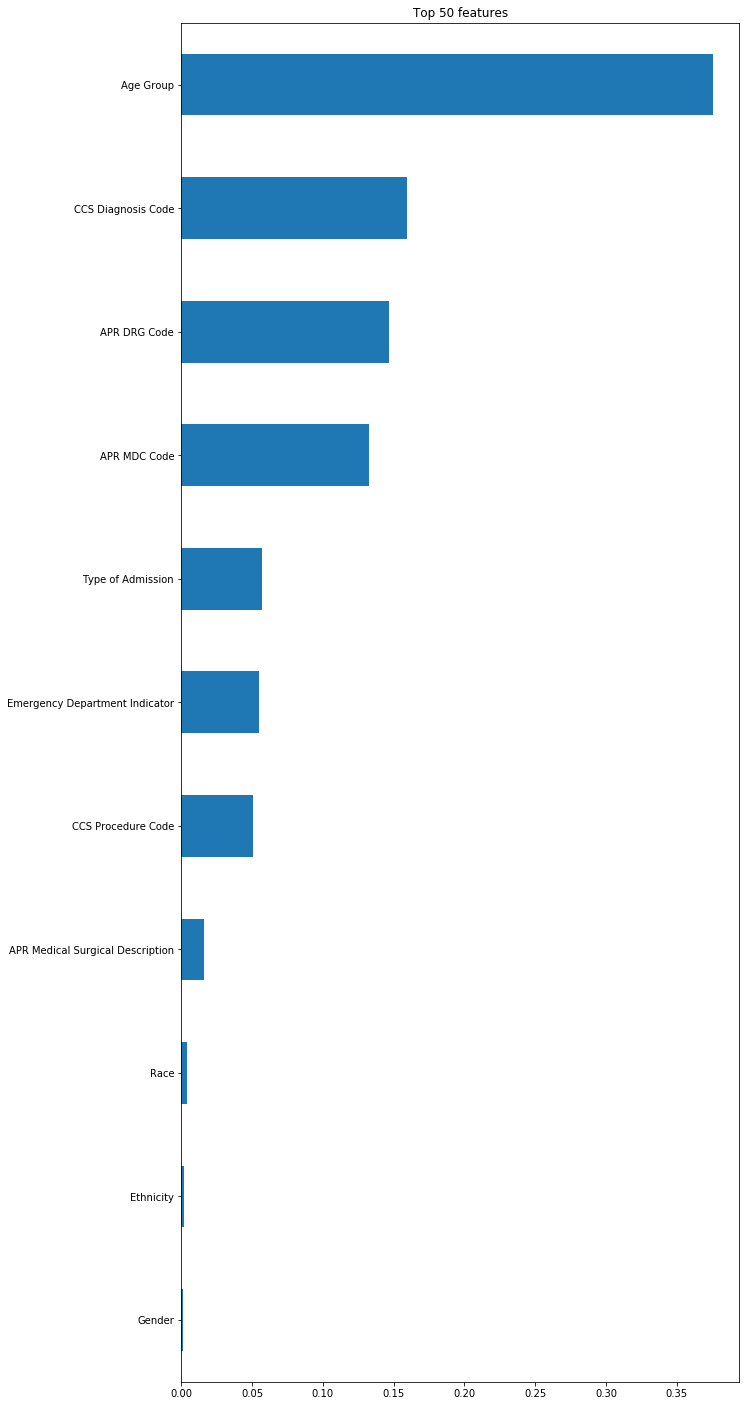

In [142]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

### Confusion Matrix

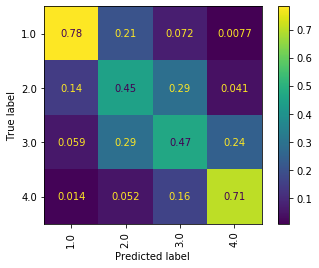

In [143]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix

# Plot
plot_confusion_matrix(pipeline, X_val, y_val, xticks_rotation= 'vertical', normalize= 'pred')

# Enlarge
plt.rcParams['figure.dpi']= 200

### Scores for Model 1

In [144]:
# Look at precision and recall for each class
# Using weighted average f1-score as an evaluation metric

from sklearn.metrics import classification_report

# Make predictions
y_pred= pipeline.predict(X_val)

# Print scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.78      0.92      0.85    227537
         2.0       0.45      0.35      0.40     86371
         3.0       0.47      0.43      0.45     64282
         4.0       0.71      0.16      0.26     20176

    accuracy                           0.68    398366
   macro avg       0.60      0.47      0.49    398366
weighted avg       0.66      0.68      0.65    398366



Remember that the baseline model had an accuracy of 57% with a weighted average f1-score of 0.42

## Model 2
- Include all of the features except for geographic data

In [145]:
# Set features and target
# Define target vector and feature matrices

# Including all features except for target and geographic data

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Gender',
    'Race',
    'Ethnicity',
    'Length of Stay',
    'Type of Admission',
    'CCS Diagnosis Code',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR MDC Code',
    'APR Medical Surgical Description',
    'Payment Typology 1',
    'Payment Typology 2',
    'Payment Typology 3',
    'Abortion Edit Indicator',
    'Emergency Department Indicator',
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [148]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)
)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.8089287294402192
Validation Accuracy: 0.7036494078309896


### Scores for Model 2

In [149]:
# Make predictions
y_pred= pipeline.predict(X_val)

# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.84      0.90      0.87    227537
         2.0       0.48      0.44      0.46     86371
         3.0       0.50      0.49      0.49     64282
         4.0       0.60      0.27      0.38     20176

    accuracy                           0.70    398366
   macro avg       0.60      0.53      0.55    398366
weighted avg       0.69      0.70      0.69    398366



Model 2 bumped the evaluation scores up 2-3 points each.

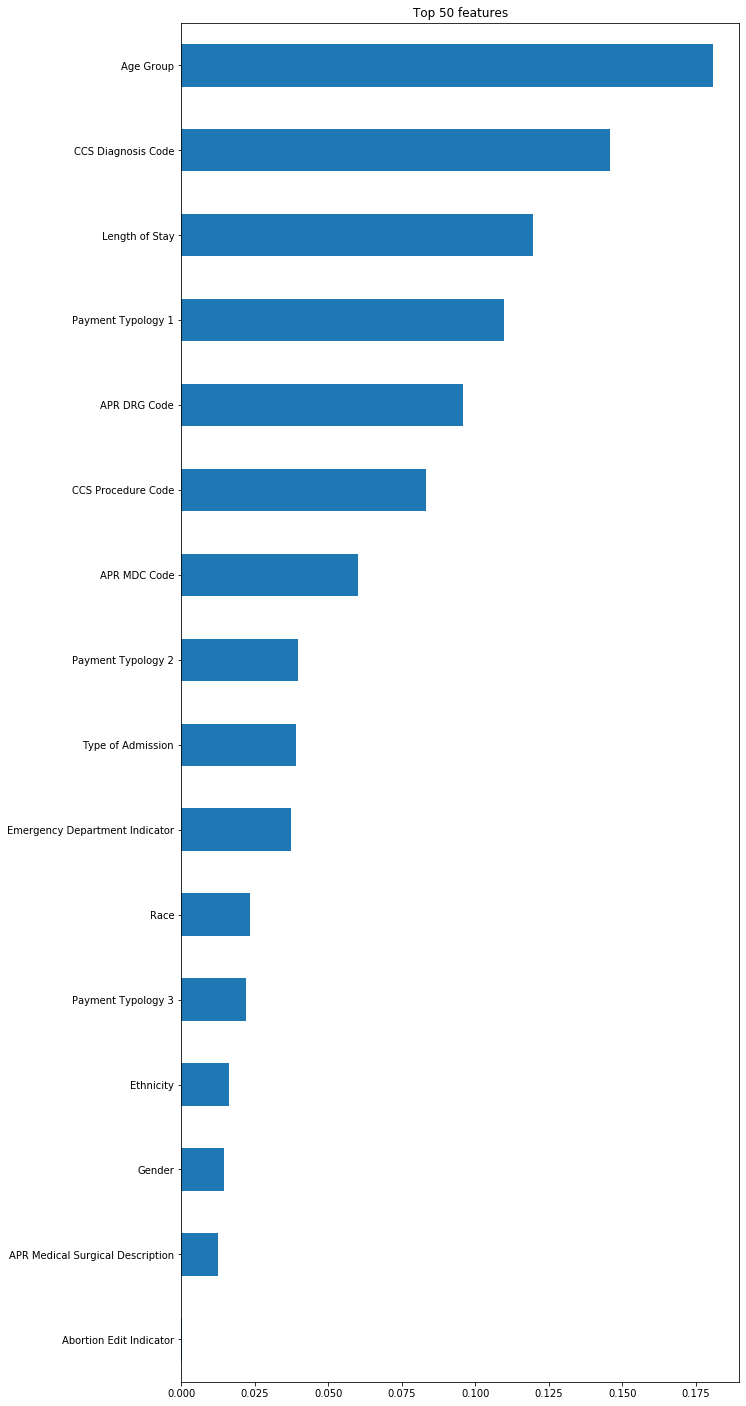

In [150]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

#### Permutation importances

In [151]:
# You can't use a pipeline in eli5
# Need to transform data and fit model before inputting into PermutationImportance

# Create pipeline to transform data
processor = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler()
)

# Transform the data
X_train_transformed = processor.fit_transform(X_train)
X_val_transformed = processor.transform(X_val)

# Define model with parameters
model = RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)

# Fit the model to train data
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [152]:
# Install eli5 on anaconda environment
# conda install -c conda-forge eli5

In [153]:
# Import
import eli5
from eli5.sklearn import PermutationImportance

# Define permuter and parameters
permuter= PermutationImportance(model, scoring= 'accuracy', n_iter= 5, random_state= 42)

# Fit permutation importance to transformed validation data
permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=20,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_frac

In [154]:
# Show weights graphic

# Define feature labels
feature_labels = X_val.columns.tolist()

# Run and print function
eli5.show_weights(permuter, top= None, feature_names= feature_labels)

Weight,Feature
0.0717 ± 0.0014,Age Group
0.0397 ± 0.0011,CCS Diagnosis Code
0.0396 ± 0.0007,Length of Stay
0.0204 ± 0.0006,APR DRG Code
0.0204 ± 0.0004,CCS Procedure Code
0.0156 ± 0.0004,APR MDC Code
0.0097 ± 0.0007,Payment Typology 1
0.0082 ± 0.0002,APR Medical Surgical Description
0.0047 ± 0.0003,Type of Admission
0.0047 ± 0.0005,Emergency Department Indicator


### XGBoost

In [155]:
# Import
from xgboost import XGBClassifier

# Create pipeline using XGBoostClassifier
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    XGBClassifier(n_estimators= 30, random_state= 42, n_jobs= -1)
)

# Fit pipeline to train data
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Age Group', 'Gender', 'Race',
                                      'Ethnicity', 'Length of Stay',
                                      'Type of Admission',
                                      'APR Medical Surgical Description',
                                      'Payment Typology 1',
                                      'Payment Typology 2',
                                      'Payment Typology 3',
                                      'Abortion Edit Indicator',
                                      'Emergency Department Indicator'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value'...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
  

In [156]:
# Import
from sklearn.metrics import accuracy_score

# Make predictions
y_pred= pipeline.predict(X_val)

# Print error metric
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.6711491442542787


In [157]:
# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.77      0.92      0.84    227537
         2.0       0.44      0.34      0.38     86371
         3.0       0.47      0.39      0.43     64282
         4.0       0.65      0.13      0.21     20176

    accuracy                           0.67    398366
   macro avg       0.58      0.45      0.47    398366
weighted avg       0.64      0.67      0.64    398366



XGBoost did not improve the evaluation metrics from random forest

## Model 3
- Feature engineer: distance to hospital
- Feature engineer: did they require multiple methods of payment
- Clean up feature selection. Don't include ones that have low importance in the model

In [250]:
# Set features and target
# Define target vector and feature matrices

# Including all features except for target and geographic data

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Gender',
    'Race',
    'Ethnicity',
    'Length of Stay',
    'Type of Admission',
    'CCS Diagnosis Code',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR MDC Code',
    'APR Medical Surgical Description',
    'Payment Typology 1',
    'Payment Typology 2',
    'Payment Typology 3',
    'Abortion Edit Indicator',
    'Emergency Department Indicator',
    'Zip Code - 3 digits',
    'Hospital Service Area',
    'Hospital County',
    'Facility Name'
    
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [251]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)
)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.8193358201867844
Validation Accuracy: 0.7028184285933518


Scores

In [252]:
# Make predictions
y_pred= pipeline.predict(X_val)

# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.83      0.91      0.87    226874
         2.0       0.48      0.44      0.46     86218
         3.0       0.50      0.48      0.49     64241
         4.0       0.62      0.26      0.36     20158

    accuracy                           0.70    397491
   macro avg       0.61      0.52      0.54    397491
weighted avg       0.69      0.70      0.69    397491



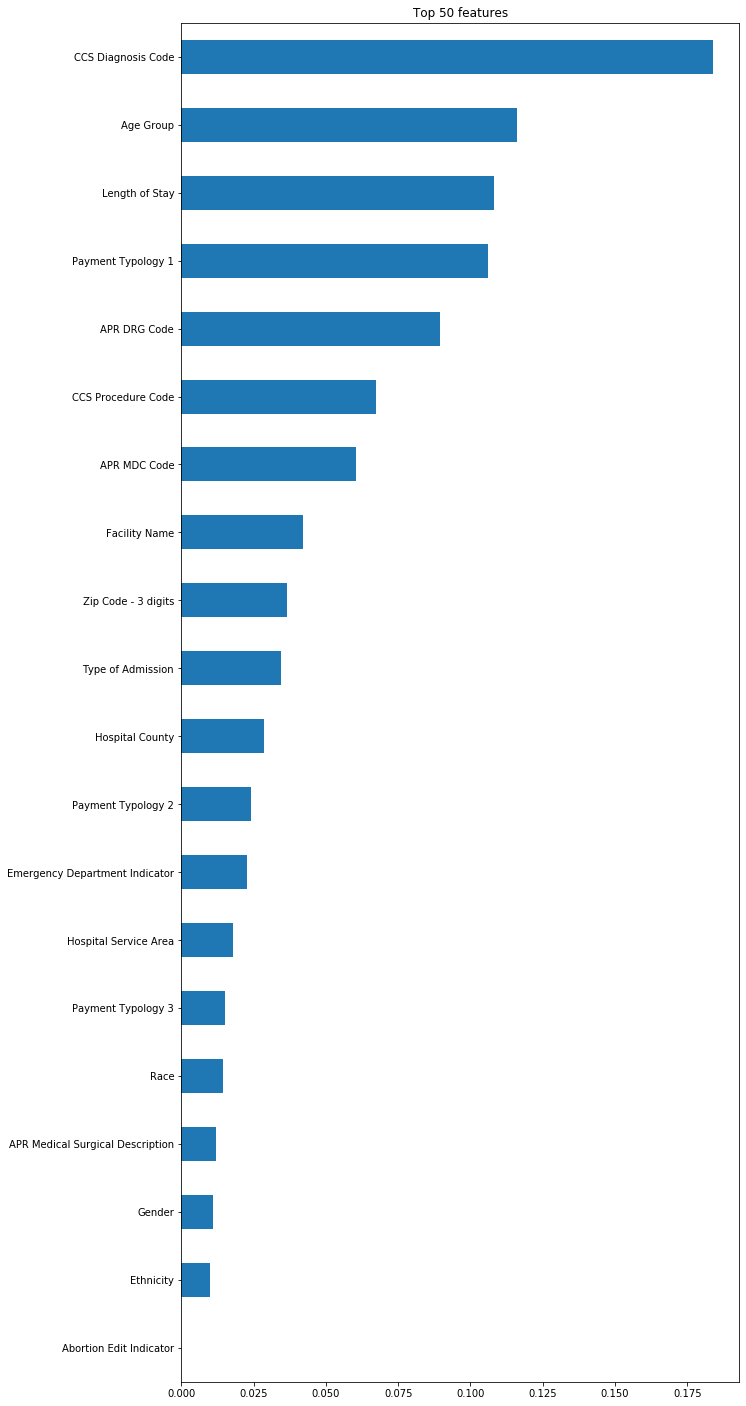

In [253]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [323]:
# You can't use a pipeline in eli5
# Need to transform data and fit model before inputting into PermutationImportance

# Create processor pipeline to transform data
processor = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler()
)

# Transform the data
X_train_transformed = processor.fit_transform(X_train)
X_val_transformed = processor.transform(X_val)

# Define model with parameters
model = RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)

# Fit the model to train data
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [256]:
# Import
import eli5
from eli5.sklearn import PermutationImportance

# Define permuter and parameters
permuter= PermutationImportance(model, scoring= 'accuracy', n_iter= 5, random_state= 42)

# Fit permutation importance to transformed validation data
permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=20,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_frac

In [257]:
# Show weights graphic

# Define feature labels
feature_labels = X_val.columns.tolist()

# Run and print function
eli5.show_weights(permuter, top= None, feature_names= feature_labels)

Weight,Feature
0.0491 ± 0.0005,Age Group
0.0434 ± 0.0009,CCS Diagnosis Code
0.0359 ± 0.0007,Length of Stay
0.0182 ± 0.0007,APR DRG Code
0.0163 ± 0.0006,CCS Procedure Code
0.0130 ± 0.0004,Payment Typology 1
0.0120 ± 0.0004,APR MDC Code
0.0051 ± 0.0003,APR Medical Surgical Description
0.0040 ± 0.0007,Type of Admission
0.0029 ± 0.0001,Emergency Department Indicator


### Work on engineering feature 'patient in or out of county'

In [239]:
geo = df_cleaned[['Hospital Service Area', 'Hospital County', 'Permanent Facility Id', 'Facility Name', 'Zip Code - 3 digits']]
geo

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Zip Code - 3 digits
0,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
1,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
2,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
3,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
4,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
...,...,...,...,...,...
2343564,Hudson Valley,Rockland,779.0,Good Samaritan Hospital of Suffern,109
2343565,Hudson Valley,Rockland,779.0,Good Samaritan Hospital of Suffern,109
2343566,Hudson Valley,Rockland,779.0,Good Samaritan Hospital of Suffern,109
2343567,New York City,Bronx,3058.0,Montefiore Med Center - Jack D Weiler Hosp of ...,104


In [240]:
geo.isnull().sum()

Hospital Service Area    0
Hospital County          0
Permanent Facility Id    0
Facility Name            0
Zip Code - 3 digits      0
dtype: int64

In [174]:
vernon = geo[geo['Facility Name']== 'Montefiore Mount Vernon Hospital']
vernon

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Zip Code - 3 digits
0,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,NaN
1,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
2,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
3,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
4,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
...,...,...,...,...,...
2291379,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
2291382,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,104
2291386,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
2291389,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105


In [175]:
vernon['Zip Code - 3 digits'].value_counts(dropna= False, normalize= True)

105    0.730782
125    0.072583
108    0.065985
104    0.055097
NaN    0.037281
107    0.022105
106    0.005609
OOS    0.004289
127    0.001980
112    0.001320
126    0.000990
114    0.000660
109    0.000660
100    0.000660
Name: Zip Code - 3 digits, dtype: float64

In [176]:
westchester = geo[geo['Hospital County']== 'Westchester']
westchester

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Zip Code - 3 digits
0,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,NaN
1,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
2,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
3,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
4,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,105
...,...,...,...,...,...
2338420,Hudson Valley,Westchester,1117.0,Northern Westchester Hospital,125
2338421,Hudson Valley,Westchester,1117.0,Northern Westchester Hospital,105
2340790,Hudson Valley,Westchester,1072.0,Montefiore New Rochelle Hospital,NaN
2343008,Hudson Valley,Westchester,1047.0,New York Presbyterian Hospital - Westchester D...,104


In [177]:
westchester['Zip Code - 3 digits'].value_counts(dropna= False, normalize= True)

105    0.394682
107    0.191683
104    0.090531
106    0.066574
108    0.056448
109    0.041167
125    0.037386
100    0.026598
OOS    0.025407
NaN    0.019347
112    0.014351
127    0.007611
126    0.006505
124    0.004510
113    0.003873
117    0.002532
114    0.002355
115    0.001450
111    0.001308
103    0.001048
120    0.000704
101    0.000553
119    0.000545
116    0.000453
110    0.000360
128    0.000327
121    0.000293
123    0.000268
122    0.000251
133    0.000117
139    0.000084
118    0.000075
148    0.000075
145    0.000075
134    0.000059
129    0.000059
137    0.000059
132    0.000050
149    0.000042
142    0.000042
146    0.000034
138    0.000034
130    0.000025
141    0.000017
136    0.000017
140    0.000017
Name: Zip Code - 3 digits, dtype: float64

Make a true/false column for if the patient lives in the same county as the hospital is located
- Make a list of zip code prefixes that the county includes, plus NaN values as we will assume they were in the county as that is the majority
- Then if the value in column 'Zip Code - 3 digits' is in the list, return true. Else return flase
- Put these results in a new column called 'In County'

In [178]:
westchester_zip_codes = ['105', '106', '107', '108', np.nan]

In [179]:
in_westchester= westchester['Zip Code - 3 digits'].isin(westchester_zip_codes)
in_westchester

0           True
1           True
2           True
3           True
4           True
           ...  
2338420    False
2338421     True
2340790     True
2343008    False
2343553     True
Name: Zip Code - 3 digits, Length: 119296, dtype: bool

In [180]:
in_westchester.value_counts(normalize=True)

True     0.728734
False    0.271266
Name: Zip Code - 3 digits, dtype: float64

In [181]:
len(geo['Hospital County'].value_counts())

57

### Linear Classification Model
- Logistic regression
- SVC (Support Vector Classification)

### Partial Dependence Plot - 1 Isolated Variable

In [259]:
# # Install pdpbox in anaconda environment
# conda install -c conda-forge pdpbox

Solving environment: done

## Package Plan ##

  environment location: /Users/stevenchase/opt/anaconda3/envs/yourenvname

  added / updated specs:
    - pdpbox


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pdpbox-0.2.0               |             py_0        55.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        55.1 MB

The following NEW packages will be INSTALLED:

  pdpbox             conda-forge/noarch::pdpbox-0.2.0-py_0



pdpbox-0.2.0         | 55.1 MB   | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [308]:
# Use Ordinal Encoder, outside of a pipeline, no scaler to increase readabliity

encoder = ce.OrdinalEncoder()
X_val_encoded = encoder.fit_transform(X_val)
X_train_encoded = encoder.fit_transform(X_train)

In [260]:
# Import Partial Dependence Plot
from pdpbox.pdp import pdp_isolate, pdp_plot

In [294]:
# Model plot

# Choose feature
feature = 'Age Group'

# Set model
isolated = pdp_isolate(
    model= model,
    dataset= pd.DataFrame(X_val_encoded, columns= X_val.columns),
    model_features= X_val.columns,
    feature = feature
)

# View plot
pdp_plot(isolated, feature);

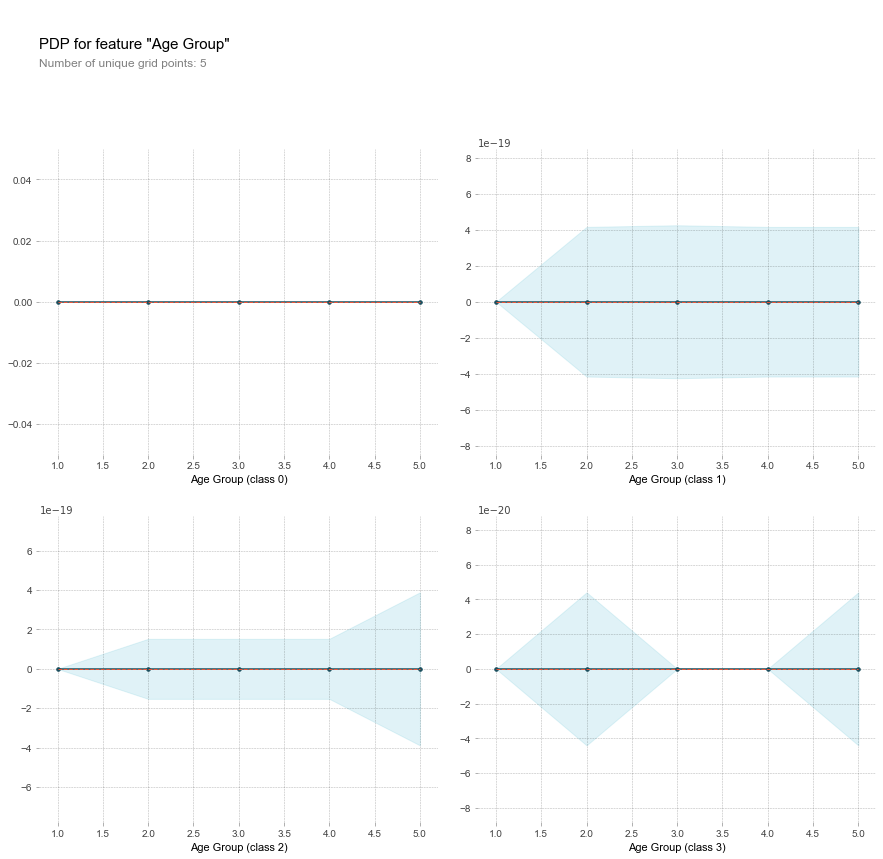

In [295]:
# # View plot
# pdp_plot(isolated, feature);

### PDP with Two Interacting Variables

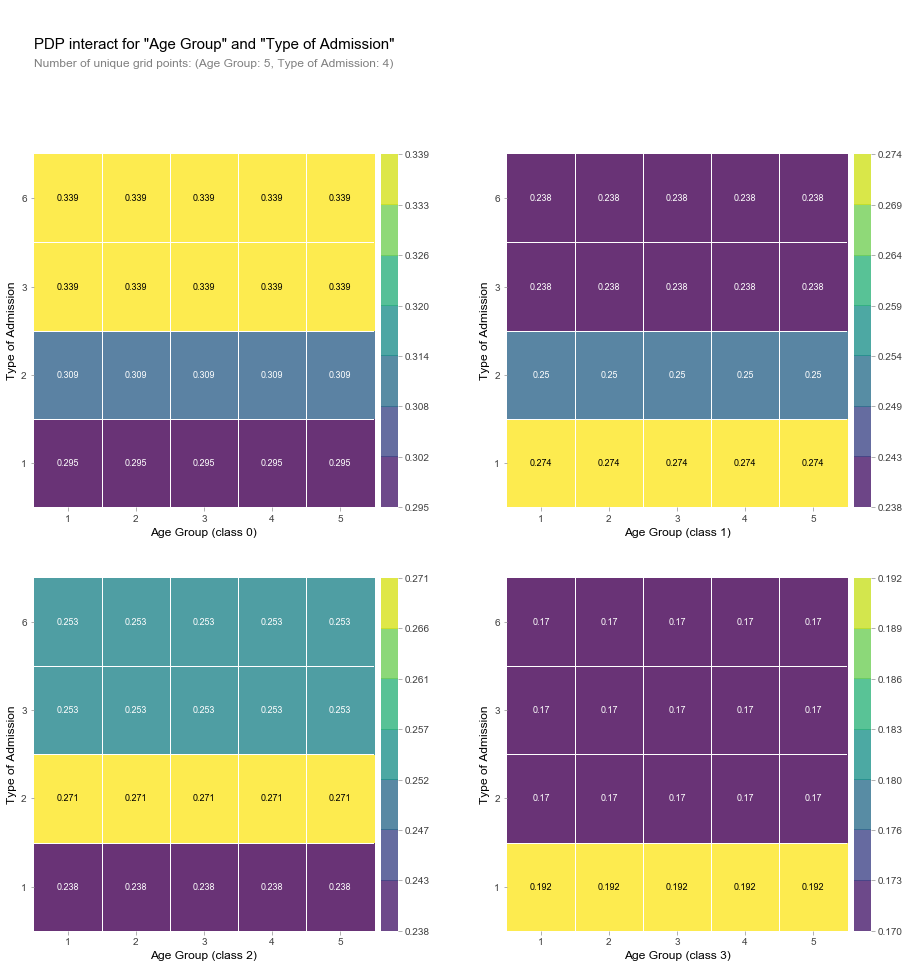

In [296]:
# Partial Dependence Plot with 2 fetures

# Import
from pdpbox.pdp import pdp_interact, pdp_interact_plot

# Define features you want to examine
features = ['Age Group', 'Type of Admission']

# Create Model
interaction = pdp_interact(
    model= model, 
    dataset= pd.DataFrame(X_val_encoded, columns= X_val.columns),
    model_features= X_val.columns,
    features= features
)

# Plot Results
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Shapley Force Plot

In [299]:
# Install shap in anaconda environment
# conda install -c conda-forge shap

Solving environment: done

## Package Plan ##

  environment location: /Users/stevenchase/opt/anaconda3/envs/yourenvname

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libcxx-9.0.1               |                1        1011 KB  conda-forge
    shap-0.35.0                |   py37h94625e5_0         394 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.4 MB

The following NEW packages will be INSTALLED:

  shap               conda-forge/osx-64::shap-0.35.0-py37h94625e5_0

The following packages will be UPDATED:

  libcxx                 pkgs/main::libcxx-4.0.1-hcfea43d_1 --> conda-forge::libcxx-9.0.1-1



libcxx-9.0.1         | 1011 KB   | ##################################### | 100% 
shap-0.35.0          | 394 KB    | ##################################### | 1

In [300]:
# Import shap
import shap

In [329]:
# Pick row of test to examine
row= X_val.iloc[[0]]
row

,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator,Zip Code - 3 digits,Hospital Service Area,Hospital County,Facility Name
1983797,30 to 49,M,White,Not Span/Hispanic,1,Elective,58,74,403,10,Surgical,Blue Cross/Blue Shield,None,None,N,N,110,Long Island,Nassau,North Shore University Hospital


In [330]:
# Get Shapley values
explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

# Plot
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row, 
    link='logit' 
)

In [331]:

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities (Sigmound curve)
)

# Changing to logit type for classification

In [333]:

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[2], 
    shap_values=shap_values[2], 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities (Sigmound curve)
)

# Changing to logit type for classification

In [334]:

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[3], 
    shap_values=shap_values[3], 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities (Sigmound curve)
)

# Changing to logit type for classification